In [1]:
# Import modules:
from tqdm import tqdm
from glob import glob
import gensim, os, emoji
from multiprocessing import Pool
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
np=pd.np

# Modules for plotting:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# Define helper functions:
from _tools import orthogonalize
from sklearn import preprocessing # l2-normalize the samples (rows). 
getCommonItems = lambda a, b: list(set(a).intersection(b))
def corr(df):
    '''' <via https://stackoverflow.com/a/48391374> Better implementation than:
        hof_df = hof_df.T.corr().stack().reset_index().rename(columns={'level_0': 'a', 'level_1': 'b', 0: 'c'})
        hof_df = hof_df.assign(d=hof_df.apply(lambda r: ''.join(set([r.a, r.b])), axis=1)).drop_duplicates(subset='d')
        hof_df = hof_df[hof_df.d.apply(len)==4].drop('d', axis=1)'''
    d = df.T.corr('spearman')
    d = d.where(pd.np.triu(pd.np.ones(d.shape)).astype(pd.np.bool))
    pd.np.fill_diagonal(d.values, pd.np.nan)
    d = d.stack().sort_values().reset_index()
    d.columns = ['a', 'b', 'c']
    return d
# Define or load Constants:
all_emjs = pd.Series(emoji.UNICODE_EMOJI).index.to_series()
nrc_df = pd.read_csv('nrc_selected.csv') # Load NRC lexicon: Has columns 'zh', 'en', 'Sad', etc.
import _lookup_tables
from _lookup_tables import emjs_face, liwc_categories, emj_ucCtgy
corpus_names = ['TwtCa', 'TwtUs', 'TwtUk', 'TwtJp', 'Weibo']
country_names= ['Canada', 'US', 'UK', 'Japan', 'China']
# Define Parameters:
model_name = 'Word2Vec'
threshold  = 1000

# Set up logger:
import logging, colorlog, colored_traceback.auto
class TqdmLoggingHandler (logging.Handler):
    '''https://stackoverflow.com/a/38739634/1147061'''
    def __init__ (self, level = logging.DEBUG):
        super (self.__class__, self).__init__ (level)
    def emit (self, record):
        try:
            msg = self.format (record)
            tqdm.write (msg)
            self.flush ()
        except (KeyboardInterrupt, SystemExit): raise
        except: self.handleError(record)   
rootLogger = logging.getLogger()            # access the root logger
logger     = logging.getLogger('ICWSM2019') # tell the program to send messages on its own behalf.
tqdmHandler = TqdmLoggingHandler()
tqdmHandler.setFormatter(colorlog.ColoredFormatter('%(log_color)s%(name)10s%(reset)s %(bold)s%(levelname)8s%(reset)s|%(message)s'))
rootLogger.addHandler(tqdmHandler)
logger.debug('Logging is up!')

We have 602 common emojis. Only 528 of them appeared more than 1000 times.


# Train Word2Vec models

In [ ]:
class Lines():
    '''a memory-friendly iterator'''
    def __init__(self, fpath='TrainingData.txt', num_lines=136017522, epoch=0):
        self.fpath = fpath
        self.num_lines = num_lines
        self.iteration = -1
        self.epoch = epoch
    def __iter__(self):
        self.iteration += 1
        with tqdm(total=self.num_lines, desc='%d-%d'%(self.epoch, self.iteration), position=self.epoch) as pbar:
            with open(self.fpath, 'r') as f:
                for line in f:
                    pbar.update()
                    yield line.split()

def work(epoch):
    lines = Lines(fpath=trainingData_fpath, num_lines=num_lines, epoch=epoch)
    model = Model(lines, iter=10, workers=24)
    model.save(model_fpath_template % epoch)

def trainGensimModels(trainingData_fpath='corpora/TwtUk2014_trainingData.txt',  # File path of the one-post-per-line training data text file
                      num_lines=4329585,                                        # number of posts in this corpus
                      model_fpath_template='gensimModels/TwtUk2014Word2Vec/%d', # where to store the trained models
                      Model = gensim.models.Word2Vec,                           # the gensim model class we should use for training
                     ):
    with Pool(processes=5) as pool:
        for res in pool.imap_unordered(work, range(5)):
            pass

trainGensimModels('corpora/TwtUk2014_trainingData.txt', 4329585  , 'gensimModels/TwtUk2014Word2Vec/%d')
trainGensimModels('corpora/TwtJp2014_trainingData.txt', 17297844 , 'gensimModels/TwtJp2014Word2Vec/%d')
trainGensimModels('corpora/Weibo2014_trainingData.txt', 136017522, 'gensimModels/Weibo2014Word2Vec/%d')
trainGensimModels('corpora/TwtCa2014_trainingData.txt', 15652578 , 'gensimModels/TwtCa2014Word2Vec/%d')
trainGensimModels('corpora/TwtUs2014_trainingData.txt', 31815608 , 'gensimModels/TwtUs2014Word2Vec/%d')

# Work With Raw, Trained Models

## Parameters -- choose one set from below

In [6]:
# Parameters -- choose one set from below:
Model = gensim.models.Word2Vec #FastText#
corpus_name = 'TwtJp'
num_epochs = 5
liwc_fpath = 'liwc_jp.csv'

Model = gensim.models.FastText #Word2Vec# 
corpus_name = 'TwtUk'
num_epochs = 5
liwc_fpath = 'liwc_en.csv'

Model = gensim.models.FastText #Word2Vec# 
corpus_name = 'TwtCa'
num_epochs = 5
liwc_fpath = 'liwc_en.csv'


Model = gensim.models.FastText #Word2Vec
corpus_name = 'Weibo'
num_epochs = 5
liwc_fpath = 'liwc_cn.csv'
nrc_df = pd.read_csv('nrc_selected.csv').drop_duplicates('zh').drop(['en', 'ja'], axis=1).set_index('zh').astype(bool)

Model = gensim.models.FastText #Word2Vec# 
corpus_name = 'TwtUs'
num_epochs = 5
liwc_fpath = 'liwc_en.csv'
nrc_df = pd.read_csv('nrc_selected.csv').drop_duplicates('en').drop(['zh', 'ja'], axis=1).set_index('en').astype(bool)

## Count LIWC Token Hits

In [4]:
model_fpath  = f'gensimModels/{corpus_name}2014{Model.__name__}/0'
model        = Model.load(model_fpath)
liwc_df      = pd.read_csv(liwc_fpath, usecols=['term', 'category']) # Load LIWC dictionaries
liwc_df.term = liwc_df.term.str.lower().str.rstrip('*')              # Drop wildcards
liwcTkns_ifFoundCnt_df = liwc_df.assign(if_captured=liwc_df.term.apply(lambda x: x in model.wv)).groupby('category').if_captured.value_counts().unstack(1).fillna(0).astype(int)
liwcTkns_ifFoundCnt_df.rename(columns={True: 'Present', False: 'Absent'}, inplace=True)
liwcTkns_ifFoundCnt_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_liwcTkns_ifFoundCnt_df')

## Compress Emojis To Coordinates

In [164]:
IF_WORK_ON_NRC      = True
IF_WORK_ON_EMJ      = True
IF_WORK_ON_LIWC     = True
IF_RESPECT_WILDCARD = True

if IF_WORK_ON_LIWC:
    # Prepare LIWC:
    liwc_df   = pd.read_csv(liwc_fpath, usecols=['term', 'category']) # Load LIWC dictionaries
    liwc_tkns = liwc_df.set_index('term').index.to_series().drop_duplicates() # get all tokens
    if IF_RESPECT_WILDCARD:
        # Split by whether wildcard is used:
        liwc_tkns_wWildcard  = liwc_tkns[liwc_tkns.str.endswith('*')]
        liwc_tkns_woWildcard = liwc_tkns[~liwc_tkns.str.endswith('*')]
        print(f'This LIWC has {len(liwc_df)} entries, {len(liwc_tkns)} tokens, {len(liwc_tkns_wWildcard)} of which are wildcarded.')
    else:
        liwc_tkns = liwc_tkns.str.rstrip('*')
    
if IF_WORK_ON_EMJ: emj_cnts = dict()

for epoch in range(num_epochs): #with tqdm(range(num_epochs), desc='Epochs') as epochs:
    print(f'Loading Model {corpus_name}2014{Model.__name__}/{epoch}...')
    model   = Model.load(f'gensimModels/{corpus_name}2014{Model.__name__}/{epoch}')
    new_index = pd.Series({k: v.index for k, v in model.wv.vocab.items()})
    vecs_df = pd.DataFrame(model.wv.vectors)
    vecs_df = vecs_df.reindex(new_index)
    vecs_df.index = new_index.index
    print(f'There are {len(vecs_df)} tokens captured in this corpora.')
    if IF_WORK_ON_NRC:
        print('Querying model for all tokens in NRC...')
        # Make nrc categorical vectors:
        def _(tkn):
            try: return model.wv.word_vec(tkn)
            except KeyError: return None
        nrc_tkns_vecs_df = nrc_df.index.to_series().apply(_).dropna().apply(pd.Series)
        nrc_ctgy_vecs_df = nrc_df.apply(lambda c: nrc_tkns_vecs_df.reindex(c[c].index).mean()).T
        print('Saving nrc-related vector lookup tables...')
        nrc_tkns_vecs_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_nrc_tkns_vecs_df')
        nrc_ctgy_vecs_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_nrc_ctgy_vecs_df')
    if IF_WORK_ON_LIWC:
        print('Querying model for all tokens in LIWC...')
        if IF_RESPECT_WILDCARD:
            # For tokens without a wildcard, we can simply query them from the massive vecs_df:
            liwc_tkns_woWildcard_vecs_df = vecs_df.reindex(liwc_tkns_woWildcard).dropna()
            # get Vector From Line For Token In Liwc With Wildcard:
            def gvflftiwww(token): 
                '''getVecFromLineForTokenInLiwcWithWildcard'''
                pbar_tkn.update()
                return vecs_df[vecs_df.index.str.startswith(token[:-1])].mean()
            with tqdm(liwc_tkns_wWildcard) as pbar_tkn: liwc_tkns_wWildcard_vecs_df = liwc_tkns_wWildcard.apply(gvflftiwww)
            # concatenate them all:
            liwc_tkns_vecs_df = pd.concat([liwc_tkns_wWildcard_vecs_df, liwc_tkns_woWildcard_vecs_df], sort=False).dropna()
        else:
            liwc_tkns_vecs_df = vecs_df.reindex(liwc_tkns).dropna()
        # Make LIWC categorical vectors:
        liwc_ctgy_vecs_df = liwc_df.merge(liwc_tkns_vecs_df, left_on='term', right_index=True).groupby('category').mean().drop(_lookup_tables.liwc_top_lv_ctgys, errors='ignore')
        print('Saving LIWC-related vector lookup tables...')
        liwc_tkns_vecs_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_liwc_tkns_vecs_df')
        liwc_ctgy_vecs_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_liwc_ctgy_vecs_df')
    if IF_WORK_ON_EMJ:
        emj_vecs_df= vecs_df.reindex(emoji.UNICODE_EMOJI).dropna() #getVectorsFromModel(model, tokens=emoji.UNICODE_EMOJI)  # Emoji vectors and coordinates:
        emj_vecs_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_emj_vecs_df') # Save:
        emj_cnts[epoch] = all_emjs.apply(getTokenCnt).dropna().astype(int)
if IF_WORK_ON_EMJ:
    emj_cnts_df = pd.DataFrame(emj_cnts).T
    emj_cnts_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_emj_cnts_df')

This LIWC has 19353 entries, 6549 tokens, 2478 of which are wildcarded.
Loading Model TwtUs2014FastText/0...
There are 324010 tokens captured in this corpora.
Querying model for all tokens in NRC...
Saving nrc-related vector lookup tables...


  0%|          | 0/2478 [00:00<?, ?it/s]

Querying model for all tokens in LIWC...


100%|██████████| 2478/2478 [09:59<00:00,  3.78it/s]


Saving LIWC-related vector lookup tables...
Loading Model TwtUs2014FastText/1...
There are 324010 tokens captured in this corpora.
Querying model for all tokens in NRC...
Saving nrc-related vector lookup tables...


  0%|          | 0/2478 [00:00<?, ?it/s]

Querying model for all tokens in LIWC...


100%|██████████| 2478/2478 [12:03<00:00,  3.55it/s]


Saving LIWC-related vector lookup tables...
Loading Model TwtUs2014FastText/2...
There are 324010 tokens captured in this corpora.
Querying model for all tokens in NRC...
Saving nrc-related vector lookup tables...


  0%|          | 0/2478 [00:00<?, ?it/s]

Querying model for all tokens in LIWC...


100%|██████████| 2478/2478 [11:04<00:00,  4.19it/s]


Saving LIWC-related vector lookup tables...
Loading Model TwtUs2014FastText/3...
There are 324010 tokens captured in this corpora.
Querying model for all tokens in NRC...
Saving nrc-related vector lookup tables...


  0%|          | 0/2478 [00:00<?, ?it/s]

Querying model for all tokens in LIWC...


100%|██████████| 2478/2478 [10:36<00:00,  3.81it/s]


Saving LIWC-related vector lookup tables...
Loading Model TwtUs2014FastText/4...
There are 324010 tokens captured in this corpora.
Querying model for all tokens in NRC...
Saving nrc-related vector lookup tables...


  0%|          | 0/2478 [00:00<?, ?it/s]

Querying model for all tokens in LIWC...


100%|██████████| 2478/2478 [12:06<00:00,  3.37it/s]


Saving LIWC-related vector lookup tables...


## Plot t-SNE maps

Compressing word vectors to coordinates in 2D via t-SNE...
Plotting...


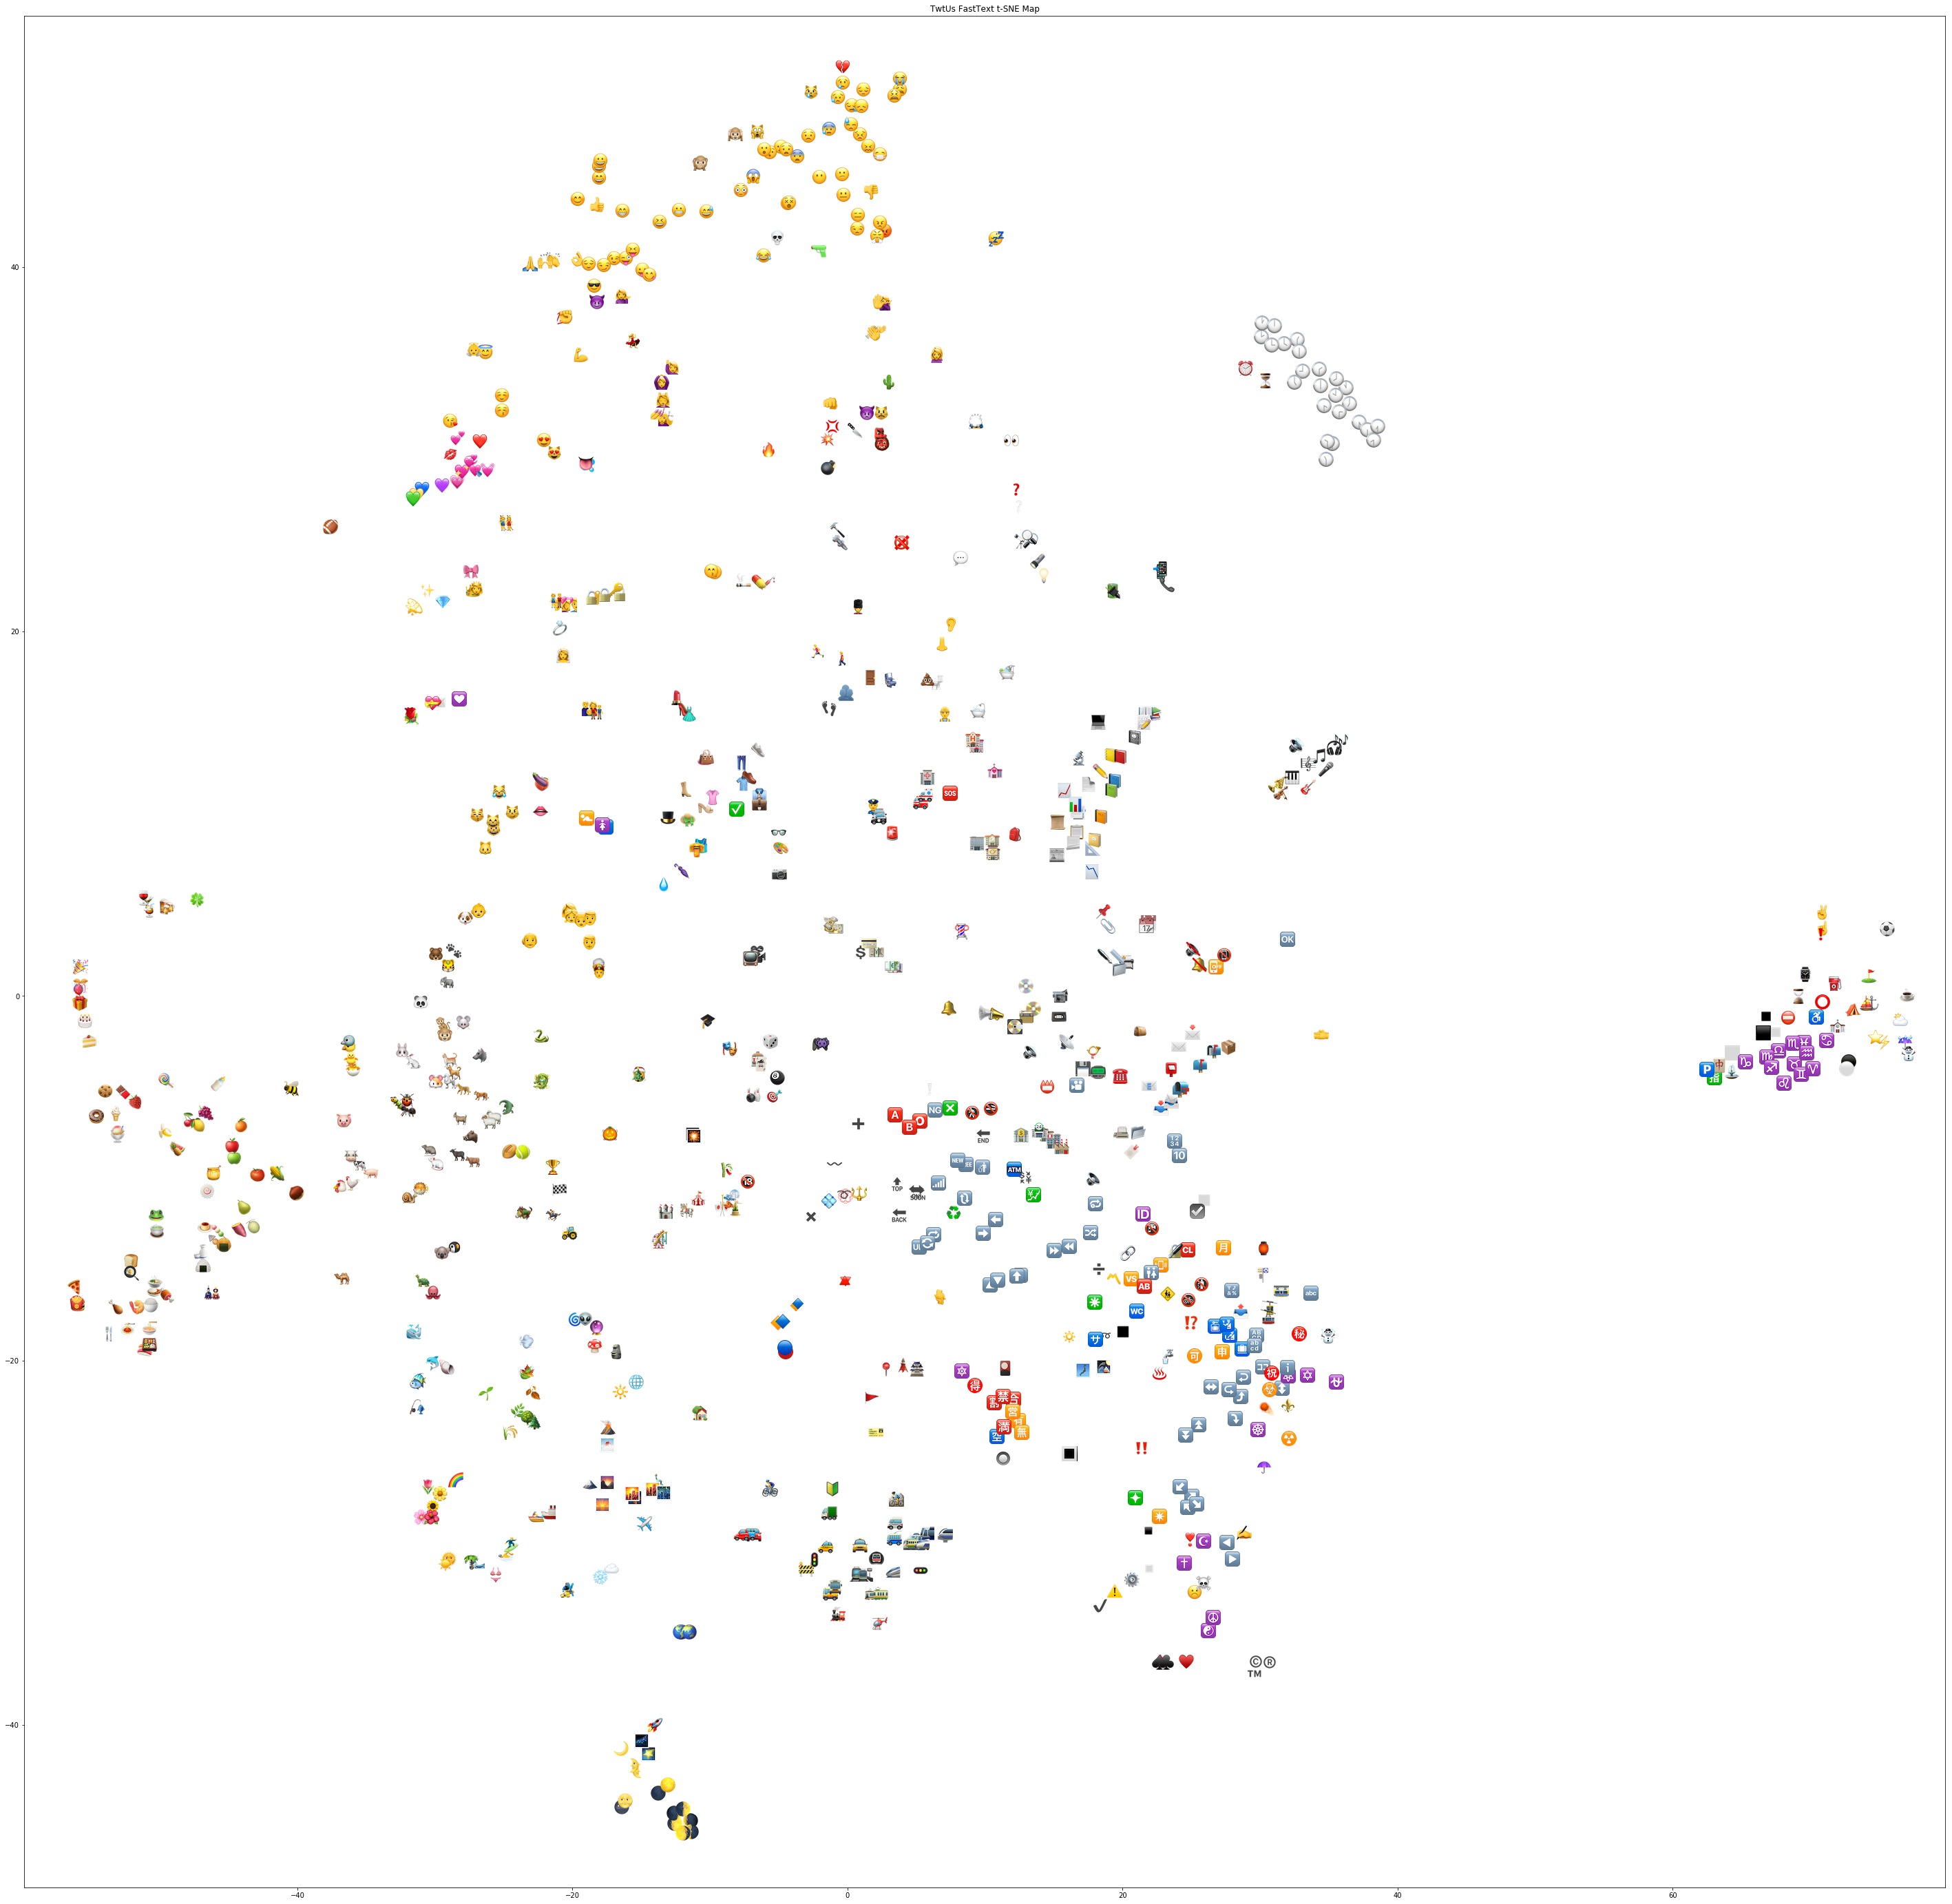

In [167]:
# Constants:
corpora = {'TwtUs', 'Weibo'}
emjs = {corpus_name: set(pd.read_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_emj_cnts_df').columns) for corpus_name in corpora}
common_emjs = set.intersection(*emjs.values())
emjs_sorted_by_occurence = pd.concat([
    pd.read_hdf('data.hdf', f'TwtUs_{Model.__name__}_emj_cnts_df'),
    pd.read_hdf('data.hdf', f'Weibo_{Model.__name__}_emj_cnts_df')
], sort=True).dropna(axis=1).sum().sort_values(ascending=False).index.to_series()

def plotEmojis(emj_coords_df, use_approx=False):
    fig, ax = plt.subplots(figsize=(50, 50))
    emjs_inModel = emj_coords_df.index.to_series()
    emjs_inModel_asUnicode = _lookup_tables.emj2unicode[emjs_inModel].str.replace('_', '-').str.lstrip('0')
    assert emjs_inModel_asUnicode.notna().all()
    assert emjs_inModel_asUnicode.nunique()==len(emjs_inModel_asUnicode)==emjs_inModel.nunique()==len(emjs_inModel)
    emjs_inModel_asImg = _lookup_tables.unicode2img[emjs_inModel_asUnicode]
    emjs_inModel_asImg.index = emjs_inModel
    if use_approx:
        unlinked = pd.Series(emjs_inModel_asImg[emjs_inModel_asImg.isna()].index)
        unlinked_rematched = unicode2img.reindex(unlinked.apply(lambda s: s[:s.rfind('-')] if s.rfind('-')>-1 else None))
        unlinked_rematched.index = unlinked
        unlinked_rematched.dropna(inplace=True)
        emjs_inModel_asImg[unlinked_rematched.index] = unlinked_rematched
    for i, row in emj_coords_df.assign(img=emjs_inModel_asImg).dropna().iterrows():
        ax.add_artist(AnnotationBbox(OffsetImage(row.img), (row.x, row.y), xycoords='data', boxcoords="offset points", frameon=False))
    ax.update_datalim(emj_coords_df.values)
    ax.autoscale()
    return ax

model         = Model.load(f'gensimModels/{corpus_name}2014{Model.__name__}/0') # Load model. We only have to load one epoch.
emj_vecs_df   = pd.read_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch0_emj_vecs_df').reindex(common_emjs)
emj_coords_df = compressWordVectors(emj_vecs_df, perplexity=15)        # Get coordinates
emj_coords_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_emj_coords_df')
# Plot:
print('Plotting...')
ax = plotEmojis(emj_coords_df)
ax.set_title(f'{corpus_name} {Model.__name__} t-SNE Map')
plt.savefig(f'tSNEs/{corpus_name}_{Model.__name__}_tSNE.png')

## Compute Emoji-to-Category Projections and then Aggregate Over Epochs

In [6]:
import seaborn as sns
%matplotlib inline
from  _tools import orthogonalize
from sklearn import preprocessing # l2-normalize the samples (rows). 
getCommonItems = lambda a, b: list(set(a).intersection(b))
from sklearn.metrics.pairwise import cosine_similarity
def project(tkns_vecs_df, axis_vecs_df, remove_common_components=True, remove_common_components_by_group=False, 
            if_orthonomalize=False, if_normalize_axis=True, if_normalize_tkns=True):
    assert len(tkns_vecs_df.columns)==len(axis_vecs_df.columns), 'Tokens and Axes must be in identical dimentionality.'
    if remove_common_components: # Optionally remove common components from all vectors being considered:
        common_components = pd.concat([tkns_vecs_df, axis_vecs_df], axis=0).mean()
        tkns_vecs_df = tkns_vecs_df-common_components
        axis_vecs_df = axis_vecs_df-common_components
    if remove_common_components_by_group: # Optionally remove common components from all vectors being considered:
        tkns_vecs_df = tkns_vecs_df-tkns_vecs_df.mean()
        axis_vecs_df = axis_vecs_df-axis_vecs_df.mean()
    if if_orthonomalize:#  axis needs speacial treatment -- orthonomalization:
        axis_vecs_ortho_m      = orthogonalize(axis_vecs_df.T.values).transpose() # orthogonalize
        axis_vecs_orthonorm_m  = preprocessing.normalize(axis_vecs_ortho_m, norm='l2') # l2-normalize ### # Turns out it doesn't matter whether it's normalized or not
        axis_vecs_orthonorm_df = pd.DataFrame(axis_vecs_orthonorm_m, index=axis_vecs_df.index) # convert to dataframe
        axis_vecs_df = axis_vecs_orthonorm_df
    else:
        if if_normalize_axis: axis_vecs_df = pd.DataFrame(preprocessing.normalize(axis_vecs_df, norm='l2'), index=axis_vecs_df.index)
        if if_normalize_tkns: tkns_vecs_df = pd.DataFrame(preprocessing.normalize(tkns_vecs_df, norm='l2'), index=tkns_vecs_df.index)
    # Calculate projection via cosine similarity:
    return pd.DataFrame(cosine_similarity(tkns_vecs_df, axis_vecs_df), columns=axis_vecs_df.index, index=tkns_vecs_df.index)

### NRC

In [7]:
IF_REMOVE_AVG_PROJ   = False
IF_SAVE_TO_HDF       = True
IF_AGG_ACROSS_EPOCHS = True

for corpus_name in corpora:
    if IF_AGG_ACROSS_EPOCHS: emj2nrcCtgy_proj_dfs = []
    with tqdm(range(num_epochs), desc=f'Epochs in {corpus_name} {Model.__name__}') as epochs:
        for epoch in epochs:
            emj_vecs_df       = pd.read_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_emj_vecs_df')
            if IF_REMOVE_AVG_PROJ: emj_vecs_df.loc['avg'] = emj_vecs_df.mean()
            nrc_ctgy_vecs_df  = pd.read_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_nrc_ctgy_vecs_df')
            emj2nrcCtgy_proj_df = project(tkns_vecs_df=emj_vecs_df, axis_vecs_df=nrc_ctgy_vecs_df, if_orthonomalize=False,
                                          remove_common_components=False, remove_common_components_by_group=True,)
                                         #if_normalize_axis=True, if_normalize_tkns=True) # Doesn't change anything
            if IF_REMOVE_AVG_PROJ:
                emj2nrcCtgy_proj_df -= emj2nrcCtgy_proj_df.loc['avg']
                emj2nrcCtgy_proj_df.drop('avg', inplace=True)
            if IF_SAVE_TO_HDF: emj2nrcCtgy_proj_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_emj2nrcCtgy_proj_df')
            if IF_AGG_ACROSS_EPOCHS: emj2nrcCtgy_proj_dfs.append(emj2nrcCtgy_proj_df)
    if IF_AGG_ACROSS_EPOCHS:
        g = pd.concat(emj2nrcCtgy_proj_dfs).reset_index().rename(columns={'index': 'emj'}).groupby('emj')
        emj2nrcCtgy_proj_avg_df = g.mean()
        emj2nrcCtgy_proj_std_df = g.std()
        # Filter for stable emojis only: .stack()[_<_.describe()['75%']].unstack(1)
        #_ = emj2nrcCtgy_proj_std_df.stack()
        if IF_SAVE_TO_HDF: # Save to HDF:
            emj2nrcCtgy_proj_avg_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_emj2nrcCtgy_proj_avg_df')
            emj2nrcCtgy_proj_std_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_emj2nrcCtgy_proj_std_df')

Epochs in TwtUs FastText: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


### LIWC

In [100]:
emj2liwcCtgy_proj_dfs = []
with tqdm(range(num_epochs), desc='Epochs') as epochs:
    for epoch in epochs:
        emj_vecs_df       = pd.read_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_emj_vecs_df')
        liwc_ctgy_vecs_df = pd.read_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_liwc_ctgy_vecs_df')
        emj2liwcCtgy_proj_df = project(tokens=emj_vecs_df, axis=liwc_ctgy_vecs_df, remove_common_components=False, if_orthonomalize=False)
        emj2liwcCtgy_proj_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_epoch{epoch}_emj2liwcCtgy_proj_df')
        emj2liwcCtgy_proj_dfs.append(emj2liwcCtgy_proj_df)
g = pd.concat(emj2liwcCtgy_proj_dfs).reset_index().rename(columns={'index': 'emj'}).groupby('emj')
emj2liwcCtgy_proj_avg_df = g.mean()
emj2liwcCtgy_proj_std_df = g.std()
# Filter for stable emojis only: .stack()[_<_.describe()['75%']].unstack(1)
#_ = emj2liwcCtgy_proj_std_df.stack()
emj2liwcCtgy_proj_avg_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_emj2liwcCtgy_proj_avg_df')
emj2liwcCtgy_proj_std_df.to_hdf('data.hdf', f'{corpus_name}_{Model.__name__}_emj2liwcCtgy_proj_std_df')

Epochs: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


# Viz - Counts Emojis in Corpora

In [176]:
# Count emojis from the two cultures:
_ = lambda corpus: pd.read_hdf('data.hdf', f'{corpus}_{model_name}_emj_cnts_df').iloc[0]
emj_cnts_byCountry_df = pd.concat(map(_, corpus_names), keys=country_names, axis=1, sort=False).dropna().astype(int)
emj_cnts_byCulture_df = pd.DataFrame({
    'West': emj_cnts_byCountry_df[['Canada', 'US', 'UK']].sum(axis=1),
    'East': emj_cnts_byCountry_df[['China', 'Japan']].sum(axis=1)})
# Take a look at the statistics:
from scipy.stats import ttest_ind
print(ttest_ind(emj_cnts_byCulture_df['West'], emj_cnts_byCulture_df['East']))
print(f'Spearman: {emj_cnts_byCulture_df.corr("spearman").iloc[0,1]}')
print(f'Pearson:  {emj_cnts_byCulture_df.corr("pearson").iloc[0,1]}')

Ttest_indResult(statistic=-2.794533768350002, pvalue=0.0052800790944619105)
Spearman: 0.7451226343073272
Pearson: 0.8815209284758879


## Figure 1: Top 20 Frequent Emojis in Each Culture

In [162]:
def work(c):
    v = (emj_cnts_byCulture_df[c]/emj_cnts_byCulture_df[c].sum()*100).sort_values(ascending=False).head(20).round(1).apply('{}'.format).reset_index()
    v.columns = pd.MultiIndex.from_tuples([[c, 'Emoji'], [c, '%']])
    v.index += 1
    v.index.rename('Rank:', inplace=True)
    return v
pd.concat([work(c) for c in ('West', 'East')], axis=1).T

Rank:         1    2    3    4    5    6    7    8    9    10   11   12   13  \
West Emoji     😂    😍    😭    😩    👌    💕    😒    😘    🙌    😊    😁    ☯    😏   
     %      16.3  4.1  4.0  2.9  2.5  2.1  2.0  2.0  1.7  1.5  1.5  1.4  1.4   
East Emoji     😂    😭    🙏    😘    😱    ❤    😍    😁    👏    💪    👍    😳    ✨   
     %      14.2  4.2  4.2  4.0  3.3  3.2  2.9  2.2  2.1  2.1  1.6  1.6  1.5   

Rank:        14   15   16   17   18   19   20  
West Emoji    👏    💯    😳    😔    🙈    🙏    👍  
     %      1.4  1.3  1.2  1.0  1.0  1.0  0.9  
East Emoji    😝    😊    😄    😜    😔    ♥    ‼  
     %      1.4  1.4  1.1  1.0  1.0  1.0  0.9

## Figure 2: Ratio of Emojis by Unicode Category Whenever One Emoji Is Used

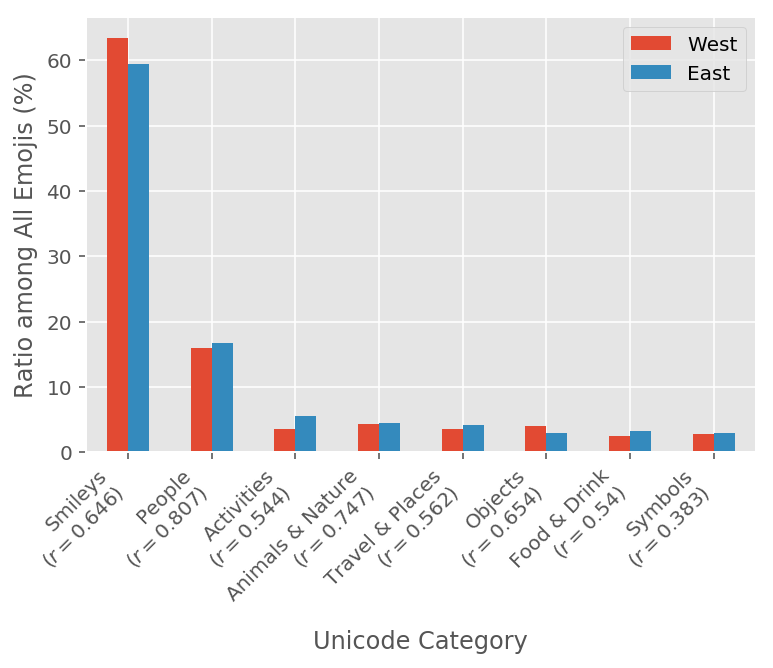

In [161]:
# Prepare data:
_ = pd.concat([emj_ucCtgy, emj_cnts_byCulture_df], axis=1, sort=False).set_index('category', append=True).dropna(how='all').fillna(0).astype(int)/emj_cnts_byCulture_df.sum()
g = _.reset_index(1).groupby('category')
corr = g.corr(method='spearman')['East'].unstack(-1)['West'].rename('SCC').drop(['Component', 'Flags'])
# Plot bars:
toPlot_df = g.sum().drop(['Component', 'Flags'])*100
toPlot_df.index = toPlot_df.index+'\n($r ='+corr.round(3).astype(str)+'$)'
toPlot_df = toPlot_df.reindex(toPlot_df.mean(axis=1).sort_values(ascending=False).index) # Sort by average decreasing order
ax = toPlot_df.plot.bar(stacked=False)#, title='Number of Emoji Occurrences by Unicode Category');
plt.ylabel('Ratio among All Emojis (%)')
plt.xlabel('Unicode Category')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")#, usetex = True)
plt.show()
#print('Normalized by Number of Posts with Emoji')

# Analyze Emojis against LIWC Categories

The Linguistic Inquiry and Word Count (LIWC) dictionary is a language-specific, many-to-many mapping of tokens (including words and word stems) and psychologically significant categories. For example, the word "cried" is in three LIWC categories: past tense, negative emotions, and sadness. LIWC categories are arranged in hierarchy: Both "postive emotions" and "negative emotions" belong to the umbrella category of "affective processes", which is in turn overarched by the supercategory of "psychological processes".

## Load Emoji-to-LIWC Similarities/Projections

In [2]:
how = 'east-against-west'
if_face_only = False

# Filter out not-so-frequent emojis:
_ = lambda corpus: pd.read_hdf('data.hdf', f'{corpus}_{model_name}_emj_cnts_df').iloc[0]
emj_cnts = pd.concat(map(_, corpus_names), keys=country_names, axis=1, sort=False).dropna().astype(int).sum(axis=1).sort_values()
emjs_common = set(emj_cnts[emj_cnts>threshold].index) # Consider only freq-enough emjs
emjs_common_face = getCommonItems(emjs_face, emjs_common)
print(f'We have {len(emj_cnts)} common emojis. Only {len(emjs_common)} of them appeared more than {threshold} times.')

# ------------------------------------------ If country-against-country ------------------------------------------
if how == 'country-against-country':
    corpus_l = 'Weibo'
    corpus_r = 'TwtUs'
    # Load "Category Vectors": Corpus-Specific Vectors For Each LIWC Category
    l_vecs_liwc_df = pd.read_hdf('data.hdf', f'{corpus_l}_{model_name}_epoch0_liwc_ctgy_vecs_df')
    r_vecs_liwc_df = pd.read_hdf('data.hdf', f'{corpus_r}_{model_name}_epoch0_liwc_ctgy_vecs_df')
    # Load Projections From Emojis To Category Vectors:
    l_liwc_projs_df = pd.read_hdf('data.hdf', f'{corpus_l}_{model_name}_emj2liwcCtgy_proj_avg_df')
    r_liwc_projs_df = pd.read_hdf('data.hdf', f'{corpus_r}_{model_name}_emj2liwcCtgy_proj_avg_df')
elif how == 'east-against-west':
    corpus_l = 'East'
    corpus_r = 'West'
    _ = lambda corpus: pd.read_hdf('data.hdf', f'{corpus}_{model_name}_emj2liwcCtgy_proj_avg_df')
    l_liwc_projs_all_df = pd.concat([_(c) for c in {'TwtJp', 'Weibo'         }], keys=['JP', 'CN'      ], sort=False, axis=1)
    r_liwc_projs_all_df = pd.concat([_(c) for c in {'TwtCa', 'TwtUs', 'TwtUk'}], keys=['CA', 'US', 'UK'], sort=False, axis=1)
    # average across countries:
    l_liwc_projs_df = l_liwc_projs_all_df.dropna(axis=0).stack().dropna().mean(axis=1).unstack()
    r_liwc_projs_df = r_liwc_projs_all_df.dropna(axis=0).stack().dropna().mean(axis=1).unstack()

# Ensure same indices and columns:
liwcCtgys_common_forProjs = getCommonItems(l_liwc_projs_df.columns, r_liwc_projs_df.columns)
emjs_common_forProjs      = getCommonItems(l_liwc_projs_df.index  , r_liwc_projs_df.index  )
emjs_common_forProjs      = getCommonItems(emjs_common_forProjs   , (emjs_common_face if if_face_only else emjs_common) )
l_liwc_projs_df = l_liwc_projs_df.reindex(index=emjs_common_forProjs, columns=liwcCtgys_common_forProjs)
r_liwc_projs_df = r_liwc_projs_df.reindex(index=emjs_common_forProjs, columns=liwcCtgys_common_forProjs)

## Figure 3: Pairwise similarities of countries in terms of Emojis learned from Word2Vec models

(measured by Pearson correlation coefficients)

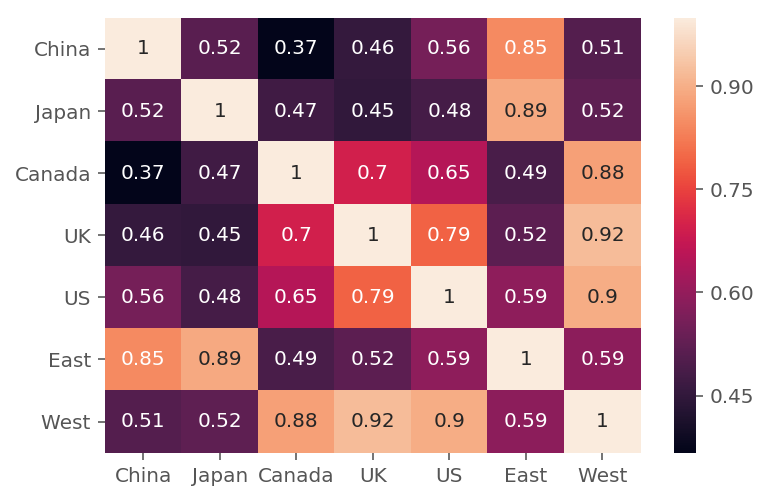

In [49]:
_ = [pd.read_hdf('data.hdf', f'{corpus_name}_{model_name}_epoch{epoch}_emj_vecs_df').reindex(emjs_common).T.corr().stack() for epoch in range(epochs)]
emj_pw_sml_df = pd.concat([pd.concat(_, axis=1).mean(axis=1).rename(corpus_name) for corpus_name in corpus_names], axis=1)
emj_pw_sml_df.index.rename(['emj1', 'emj2'], inplace=True)
emj_pw_sml_df.reset_index(inplace=True)
emj_pw_sml_df = emj_pw_sml_df[emj_pw_sml_df.emj1!=emj_pw_sml_df.emj2]
emj_pw_sml_df.set_index(['emj1', 'emj2'], inplace=True)
west_emj_pw_sml_df = emj_pw_sml_df[['TwtCa', 'TwtUs', 'TwtUk']].sum(axis=1).rename('West')
east_emj_pw_sml_df = emj_pw_sml_df[['TwtJp', 'Weibo']].sum(axis=1).rename('East')
# print West-East correlation coefficient:
corr = pd.concat([west_emj_pw_sml_df, east_emj_pw_sml_df], axis=1).corr().iloc[1, 0]
print(f'West-East Correlation is: {corr}')
# prepare the similarity matrix:
emj_pw_sml_df = emj_pw_sml_df.assign(
            West=emj_pw_sml_df[['TwtCa', 'TwtUs', 'TwtUk']].T.mean(),
            East=emj_pw_sml_df[['TwtJp', 'Weibo']].T.mean(),)
emj_pw_sml_corr_df = emj_pw_sml_df.rename(columns=dict(zip(corpus_names, country_names)))[['China', 'Japan', 'Canada', 'UK', 'US', 'East', 'West']].corr()
sns.heatmap(emj_pw_sml_corr_df, annot=True)
#plt.title('Pairwise Similarities of Countries in Terms of Pairwise Emoji Similarity as Learned via Word2Vec')

## Sort Emojis by Similarities/Correlations

### Figure 4: Grouped by LIWC

In [5]:
def getTopNdf(df, corpus_name = None, N=5, top=True):
    emojis_df = df.apply(lambda col: col.sort_values(ascending=False).index).reset_index(drop=True)
    emojis_df = emojis_df[:N] if top else emojis_df[-N:]
    getValues = lambda col: col.sort_values(ascending=False).reset_index(drop=True)
    values_df = df.apply(getValues).fillna(0).applymap(lambda v: '%d%%' % (100*v))
    values_df = values_df[:N] if top else values_df[-N:]
    #values_df = values_df.applymap(lambda x: '%0.2f'%(int(x)/100) if x!='  ' else '  ')
    topN_df = emojis_df+values_df
    topN_df.index = (topN_df.index+1).rename('Rank:')
    return topN_df

topN_df = pd.concat([
    getTopNdf(l_liwc_projs_df),
    getTopNdf(r_liwc_projs_df),
], keys=[f'{corpus_l} {model_name}', f'{corpus_r} {model_name}'], names=['Corpus:']).T

# Append Spearman correlation coefficients:
spearmans_df = liwc_spearmans.apply(lambda x: round(x, 3)).to_frame()
spearmans_df.columns = pd.MultiIndex.from_tuples([['Spearman', 'Correlation']])
topN_df = pd.concat([topN_df, spearmans_df], sort=False, axis=1)
topN_df = topN_df.reindex(liwc_spearmans.sort_values(ascending=False).index) # Sort by corr
# Set two-level index:
topN_groupbyLiwc_df = topN_df.assign(Type = topN_df.index.to_series().map(liwc_categories)).dropna()\
.reset_index().rename(columns={'index': 'Category'}).sort_values(['Type', ('Spearman', 'Correlation')], ascending=[True, False]).set_index(['Type', 'Category'])
# print Stats:
_ = liwc_spearmans.reindex(topN_groupbyLiwc_df.index.to_frame().Category).sort_values(ascending=False)
desc = _.describe()
desc['median'] = _.median()
print(desc.rename('val').to_frame())
# Save to file:
topN_groupbyLiwc_df.to_html('topN_groupbyLiwc_df.html')
# Render:
topN_groupbyLiwc_df

              val
count   31.000000
mean     0.324400
std      0.195027
min     -0.061486
25%      0.176314
50%      0.324486
75%      0.448941
max      0.734643
median   0.324486


Corpus:                          East Word2Vec                          \
Rank:                                        1     2     3     4     5   
Type                    Category                                         
Biological processes    Ingest            🍝80%  🍜78%  🍛78%  🍴78%  🍮77%   
                        Body              👃72%  ♂64%  🛀64%  💉63%  💊62%   
                        Health            💉72%  💊72%  🏥69%  😷69%  🚑61%   
                        Sexual            ♂60%  ♀59%  🔞58%  ▪57%  🏇57%   
Cognitive processes     Certain           💖63%  💌62%  💜62%  💏61%  💋61%   
                        Cause             🔍61%  ⬇60%  ➡60%  ♻60%  ⚠59%   
                        Insight           🙋58%  😭57%  👩57%  💢57%  🚺56%   
                        Tentat            ⛄59%  ☔58%  🏇57%  ⛅57%  🌵57%   
                        Discrep           🌳60%  🌺60%  🌻60%  🌈59%  ☀59%   
Linguistic Dimensions   Negate            ⭕58%  🏇57%  🍵57%  🌘57%  💳56%   
Other Grammar           Number            ♂57%  🔥57%  🙅57%  ❕56%  ⭕56%   
                        Quant             😼58%  👾57%  🐑57%  🐤57%  🏀56%   
Perceptual processes    See               👓62%  👀60%  🌁59%  🌠59%  🐚59%   
                        Feel              🌂65%  🍂64%  🍃61%  🌿60%  🌱60%   
                        Hear              🎹75%  🎷75%  🎧75%  🎤73%  🔊73%   
Personal concerns       Death             🎅63%  🐋61%  🌅61%  🌄61%  🎄61%   
                        Home              🏠68%  🚪67%  🏡67%  🚽67%  🛀65%   
                        Leisure           🏂67%  🎾65%  🚲64%  🏄63%  🎬63%   
                        Money             💸73%  💰70%  💴69%  👛64%  💵63%   
                        Relig             🌍59%  🐜59%  💸59%  🙏59%  🌎58%   
                        Work              ✏59%  📝59%  💯58%  💌58%  🎓58%   
Psychological Processes Anger             😡73%  👎71%  💢70%  👿70%  😠70%   
                        Anx               😞65%  💧63%  💔62%  💦62%  😥62%   
                        Negemo            🚬61%  😔60%  😞60%  😪59%  🙍59%   
                        Sad               🐘59%  😢59%  ®58%  🍐58%  🐨58%   
                        Posemo            👴58%  👵58%  🍊57%  🍏56%  👼56%   
Relativity              Motion            🏃67%  🚗67%  🚲66%  🚄66%  🚌65%   
                        Space             🚉64%  🚃60%  🚄59%  🚶58%  🚋58%   
                        Time              🌷60%  🌝59%  🍁58%  ⏰58%  🍀58%   
Social processes        Family            👨70%  👶69%  👵68%  👩66%  👴64%   
                        Friend            👮61%  👊59%  💣58%  🚙58%  ❌58%   

Corpus:                          West Word2Vec                          \
Rank:                                        1     2     3     4     5   
Type                    Category                                         
Biological processes    Ingest            🍝78%  🍤76%  🍖76%  🍣76%  🍗75%   
                        Body              🚿67%  💇67%  👃65%  🍑65%  😷65%   
                        Health            💊63%  😷62%  😣62%  ☑62%  😖62%   
                        Sexual            💋59%  🚿58%  🛀58%  👅58%  🌃58%   
Cognitive processes     Certain           🔑62%  💯62%  👈61%  👆61%  💫61%   
                        Cause             🌿64%  📱63%  🍍61%  🍇61%  🍌60%   
                        Insight           🔐60%  👫60%  🔑59%  💏59%  💑58%   
                        Tentat            🌠58%  💫57%  💘57%  💭57%  💗57%   
                        Discrep           🙏60%  👉59%  🐾59%  👇58%  👼57%   
Linguistic Dimensions   Negate            😭58%  💔58%  😹57%  😿57%  💸57%   
Other Grammar           Number            🔫57%  👴57%  💑57%  😴57%  💏57%   
                        Quant             📚57%  💉56%  💵56%  🎓56%  🎉55%   
Perceptual processes    See               🌑58%  🌌58%  🔵57%  🔴57%  🌕57%   
                        Feel              ☔64%  💧62%  🎶62%  🌞60%  🎧60%   
                        Hear              🎹78%  🎼77%  🎷76%  🎤75%  🎵74%   
Personal concerns       Death             🆘64%  🎃62%  🌠61%  🌲61%  🎅61%   
                        Home              🏠63%  🌲61%  🏡61%  🌳60%  👜60%   
   

### Figure 6: Grouped by Unicode.org Categories

In [84]:
# parameters:
N = 10
# constants:
emj_ucCtgy = pd.read_csv('Unicode_list_of_emojis.csv').set_index('emoji').category
ucCtgys = ['Smileys', 'People', 'Animals & Nature', 'Food & Drink', 'Travel & Places', 'Activities', 'Objects', 'Symbols']

ucCtgy_spearmans = []
for ucCtgy in ucCtgys:
    emjs_thisUcCtgy = emj_ucCtgy.loc[emj_ucCtgy==ucCtgy].index
    l_df = l_liwc_projs_df.reindex(emjs_thisUcCtgy)
    r_df = r_liwc_projs_df.reindex(emjs_thisUcCtgy)
    spearmans_thisUcCtgy = calcSpearmans(r_df, l_df).dropna().rename('correlation')
    stats = pd.Series({
         'mean'  : spearmans_thisUcCtgy.mean(), 
         'var'   : spearmans_thisUcCtgy.var(), 
         'stddev': spearmans_thisUcCtgy.std(), 
         'median': spearmans_thisUcCtgy.median()}).apply(lambda s: '%.3f'%s)
    stats['#'] = '%d/%d'%(len(getCommonItems(emjs_thisUcCtgy, emjs_common)), len(emjs_thisUcCtgy))
    # convert to string, controlling the decimals:
    spearmans_thisUcCtgy = spearmans_thisUcCtgy.apply(lambda s: '%.3f'%s)
    results_thisUcCtgy = []
    spearmans_thisUcCtgy_df = pd.concat([spearmans_thisUcCtgy.head(N), spearmans_thisUcCtgy.tail(N)]).reset_index()
    spearmans_thisUcCtgy_df.columns = pd.MultiIndex.from_tuples([[ucCtgy, 'Emoji'], [ucCtgy, 'SCC']])
    stats_df = stats.to_frame().assign(dummy='')
    stats_df.columns = spearmans_thisUcCtgy_df.columns
    spearmans_thisUcCtgy_df = pd.concat([spearmans_thisUcCtgy_df, stats_df])
    ucCtgy_spearmans.append(spearmans_thisUcCtgy_df)

_ = pd.concat(ucCtgy_spearmans, axis=1, sort=False)
_.columns.rename(['Unicode Categories', ''], inplace=True)
_.index = pd.Series(['Top %d' % i for i in range(1, 11)]+['Bottom %d' % i for i in range(1, 11)]+['Mean','Var.', 'Std. Dev.', 'Median', '# captured / # Emojis in This Category'])
_

Unicode Categories                      Smileys          People         \
                                          Emoji     SCC   Emoji    SCC   
Top 1                                         💩   0.642       💏  0.607   
Top 2                                         💛   0.583       💪  0.565   
Top 3                                         💜   0.576       👭  0.551   
Top 4                                         💘   0.576       👰  0.528   
Top 5                                         💚   0.559       💑  0.526   
Top 6                                         💙   0.553       👊  0.522   
Top 7                                         💞   0.525       🚴  0.519   
Top 8                                         💋   0.524       🚣  0.496   
Top 9                                         💫   0.510       👶  0.490   
Top 10                                        💗   0.486       👫  0.472   
Bottom 1                                      😝   0.127       👵  0.182   
Bottom 2                                      😸   0.124       🚶  0.181   
Bottom 3                                      🙊   0.112       👌  0.180   
Bottom 4                                      😆   0.108       👀  0.180   
Bottom 5                                      😀   0.100       🙌  0.178   
Bottom 6                                      🙈   0.096       ☝  0.163   
Bottom 7                                      💦   0.094       👣  0.144   
Bottom 8                                      😗   0.033       💂  0.125   
Bottom 9                                      👻  -0.111       🏇  0.098   
Bottom 10                                     😬  -0.132       👥  0.041   
Mean                                      0.310           0.326          
Var.                                      0.018           0.016          
Std. Dev.                                 0.135           0.128          
Median                                    0.317           0.320          
# captured / # Emojis in This Category  105/146          68/291          

Unicode Categories                     Animals & Nature         Food & Drink  \
                                                  Emoji     SCC        Emoji   
Top 1                                                 🐮   0.458            ☕   
Top 2                                                 🌹   0.451            🍓   
Top 3                                                 🌲   0.447            🍌   
Top 4                                                 💐   0.441            🍻   
Top 5                                                 🌳   0.435            🍴   
Top 6                                                 🐻   0.396            🍼   
Top 7                                                 🌻   0.394            🍵   
Top 8                                                 🌼   0.392            🍝   
Top 9                                                 🌸   0.359            🍇   
Top 10                                                🐶   0.354            🍺   
Bottom 1                                              🐏   0.090            🍖   
Bottom 2                                              🐢   0.072            🍯   
Bottom 3                                              🐙   0.071            🍚   
Bottom 4                                              🐐   0.065            🌽   
Bottom 5                                              🐸   0.055            🍳   
Bottom 6                                              🐴   0.035            🍘   
Bottom 7                                              🍂   0.034            🍣   
Bottom 8                                              🐋   0.013            🍙   
Bottom 9                                              🐄   0.003            🍤   
Bottom 10                                             🐍  -0.246            🍠   
Mean                                              0.218                0.214   
Var.                                              0.016                0.021   
Std. Dev.                                         0.127                0.144   
M

In each cell, the number is the Spearman Correlation Coefficient computed for the shown emoji between the two corpora. The two arrays (on which this Coefficient is calculated) contain the cosine similarities of the emoji vector to each of the LIWC category vectors. It is worth noticing that these emoji-to-LIWC vectorial consine similarities are pre-computed and then standardized (to 0~100) with in each LIWC category.

# Quiver Plot
1. Hofstede dataset is retrieved from [here](https://geerthofstede.com/research-and-vsm/dimension-data-matrix/https://geerthofstede.com/wp-content/uploads/2016/08/6-dimensions-for-website-2015-08-16.csv).
2. A Pearson correlation between the *6D Hofstede vectors* is computed for each pair of countries.
3. A Pearson correlation between the *18662D LIWC-Emoji Pairwise Projection Vector* is computed for each pair of countries.
4. The two columns of correlations are concatencated together.
5. Rows are grouped by whether they are eastern or western, and in-group mean for each of the two columns are computed.

## Prepare data to plot

### load sub-dataframes

#### Emoji-to-LIWC-category projection vectors and Hofstede's Country Data 

In [3]:
# emj2liwcCtgy projs
top_freq_emjs = pd.concat([
    pd.read_hdf('data.hdf', 'TwtUs_Word2Vec_emj_cnts_df').iloc[0],
    pd.read_hdf('data.hdf', 'TwtUk_Word2Vec_emj_cnts_df').iloc[0],
    pd.read_hdf('data.hdf', 'TwtCa_Word2Vec_emj_cnts_df').iloc[0],
    pd.read_hdf('data.hdf', 'TwtJp_Word2Vec_emj_cnts_df').iloc[0],
    pd.read_hdf('data.hdf', 'Weibo_Word2Vec_emj_cnts_df').iloc[0]], sort=False, axis=1).sum(axis=1).sort_values(ascending=False).index
proj_df = pd.concat([
    pd.read_hdf('data.hdf', 'TwtCa_Word2Vec_emj2liwcCtgy_proj_avg_df'),
    pd.read_hdf('data.hdf', 'TwtUs_Word2Vec_emj2liwcCtgy_proj_avg_df'),
    pd.read_hdf('data.hdf', 'TwtUk_Word2Vec_emj2liwcCtgy_proj_avg_df'),
    pd.read_hdf('data.hdf', 'TwtJp_Word2Vec_emj2liwcCtgy_proj_avg_df'),
    pd.read_hdf('data.hdf', 'Weibo_Word2Vec_emj2liwcCtgy_proj_avg_df'),
], keys=['CA', 'US', 'UK', 'JP', 'CN'], sort=False, axis=1).dropna(axis=0).reindex(top_freq_emjs).dropna().head(200)
proj_corr_df = corr(proj_df.stack().dropna().reset_index(drop=True).T.sort_index())
# hofs "country culture" data
hofs_df = pd.read_csv('6-dimensions-for-website-2015-08-16.csv', delimiter=';', na_values='#NULL!').set_index('ctr').drop('country', axis=1).dropna().astype(int).loc[['CHI', 'JPN', 'CAN', 'GBR', 'USA']] # via <https://geerthofstede.com/research-and-vsm/dimension-data-matrix/https://geerthofstede.com/wp-content/uploads/2016/08/6-dimensions-for-website-2015-08-16.csv>
hofs_df.index = ['China', 'Japan', 'Canada', 'UK', 'US']
hofs_df.loc['East'] = hofs_df.loc[['China', 'Japan']].mean()
hofs_df.loc['West'] = hofs_df.loc[['Canada', 'UK', 'US']].mean()

#### Emoji-to-Eckman-words projection vectors
We now want to add Eckman points to the quiver plots too.

In [9]:
# constants:
emoNouns_df = pd.DataFrame.from_dict({'en': ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'],
                                      'cn': ['愤怒'  , '厌恶'    , '恐惧', '快乐'      , '悲伤'    , '惊讶'],
                                      'jp': ['怒り'  , '嫌悪'    , '恐怖', '幸福'      , '悲しみ'  , '驚き']}, orient='index')
emoAdjs_df  = pd.DataFrame.from_dict({'en': ['angry', 'disgusted', 'terrified', 'happy', 'sad'   , 'surprised'],
                                      'cn': ['生气'  , '恶心'      , '害怕'     , '开心'  , '伤心'  ,  '吃惊'    ],
                                      'jp': ['怒'    , '嫌'       , '怖い'     , '幸せ'  , '悲しい' , '驚い'    ]}, orient='index')
emotions_df = pd.concat([emoAdjs_df, emoNouns_df], axis=1, sort=False)

corpora_to_lang = {'TwtCa': 'en', 'TwtUs': 'en', 'TwtUk': 'en', 'TwtJp': 'jp', 'Weibo': 'cn'}
corpora = set(corpora_to_lang)
# Load Eckman vectors from model:
import gensim
Model = gensim.models.Word2Vec
def getVectorsFromModel(model, tokens):
    data = dict()
    for token in tokens:
        try: data[token] = model.wv.get_vector(token)
        except KeyError: pass
    return pd.DataFrame.from_dict(data, orient='index')
for corpus in corpora:
    eckman_words = emotions_df.loc[corpora_to_lang[corpus]]
    for epoch in range(5):
        print(f'Loading Model epoch #{epoch} of {corpus}...')
        model = Model.load(f'gensimModels/{corpus}2014{Model.__name__}/{epoch}')
        eckman_vecs_df = getVectorsFromModel(model, eckman_words) # Get Vectors
        eckman_vecs_df.to_hdf('data.hdf', f'{corpus}_Word2Vec_epoch{epoch}_eckman_vecs_df')
# Make Projection:
def work(tkns_vecs_df, axis_vecs_df, remove_common_components=True):
    assert len(tkns_vecs_df.columns)==len(axis_vecs_df.columns), 'Tokens and Axes must be in identical dimentionality.'
    # Optionally remove common components from all vectors being considered:
    common_components = pd.concat([tkns_vecs_df, axis_vecs_df], axis=0).mean() if remove_common_components else pd.Series([0]*len(tkns_vecs_df.columns))
    tkns_vecs_df = tkns_vecs_df-common_components
    axis_vecs_df = axis_vecs_df-common_components
    #  axis needs speacial treatment -- orthonomalization:
    axis_vecs_ortho_m      = orthogonalize(axis_vecs_df.T.values).transpose() # orthogonalize
    axis_vecs_orthonorm_m  = preprocessing.normalize(axis_vecs_ortho_m, norm='l2') # l2-normalize 
    axis_vecs_orthonorm_df = pd.DataFrame(axis_vecs_orthonorm_m, index=axis_vecs_df.index) # convert to dataframe
    return pd.DataFrame(cosine_similarity(tkns_vecs_df, axis_vecs_orthonorm_df), columns=axis_vecs_df.index, index=tkns_vecs_df.index)
with tqdm(corpora) as pbar:
    for corpus in pbar:
        lang = corpora_to_lang[corpus]
        eckman_nouns = emoNouns_df.loc[lang]
        eckman_adjs  = emoAdjs_df.loc[lang]
        emj2eck_proj_dfs = []
        for epoch in range(5):
            emoji_vecs_df  = pd.read_hdf('data.hdf', f'{corpus}_{Model.__name__}_epoch{epoch}_emj_vecs_df')
            eckman_vecs_df = pd.read_hdf('data.hdf', f'{corpus}_{Model.__name__}_epoch{epoch}_eckman_vecs_df')
            # Split into 2 sets:
            eckmanN_vecs_df = eckman_vecs_df.loc[eckman_nouns]
            eckmanA_vecs_df = eckman_vecs_df.loc[eckman_adjs]
            # get projections:
            emj2eckA_proj_df = work(emoji_vecs_df, eckmanA_vecs_df, remove_common_components=True)
            emj2eckN_proj_df = work(emoji_vecs_df, eckmanN_vecs_df, remove_common_components=True)
            # concatenate and save:
            emj2eck_proj_df = pd.concat([emj2eckA_proj_df, emj2eckN_proj_df], axis=1)
            emj2eck_proj_df.to_hdf('data.hdf', f'{corpus}_Word2Vec_epoch{epoch}_emj2eck_proj_df')
            emj2eck_proj_dfs.append(emj2eck_proj_df)
        # average across 5 epochs:
        emj2eck_proj_df = pd.concat([i.stack() for i in emj2eck_proj_dfs], axis=1).mean(axis=1).unstack()
        emj2eck_proj_df.columns = emotions_df.loc['en'] # translate eckman words to english
        emj2eck_proj_df.to_hdf('data.hdf', f'{corpus}_Word2Vec_avg_emj2eck_proj_df')
# Load them back from the HDF dump file:
all_emj2eck_proj_df = pd.concat([
    pd.read_hdf('data.hdf', 'TwtCa_Word2Vec_avg_emj2eck_proj_df'),
    pd.read_hdf('data.hdf', 'TwtUs_Word2Vec_avg_emj2eck_proj_df'),
    pd.read_hdf('data.hdf', 'TwtUk_Word2Vec_avg_emj2eck_proj_df'),
    pd.read_hdf('data.hdf', 'TwtJp_Word2Vec_avg_emj2eck_proj_df'),
    pd.read_hdf('data.hdf', 'Weibo_Word2Vec_avg_emj2eck_proj_df'),
], keys=['CA', 'US', 'UK', 'JP', 'CN'], sort=False, axis=1).dropna(axis=0).reindex(top_freq_emjs).dropna().head(200)
all_emj2eck_proj_corr_df = corr(all_emj2eck_proj_df.stack().dropna().reset_index(drop=True).T.sort_index())

100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


### Combine them

In [11]:
df = pd.concat([proj_corr_df.set_index(['a', 'b']).c.rename('proj'),
                hofs_corr_df.set_index(['a', 'b']).c.rename('hofs'),
                proj_df.T.reset_index(1).groupby('category').apply(lambda df: corr(df.sort_index().drop('category', axis=1)).set_index(['a', 'b']).c).unstack(0).dropna(axis=1),
                all_emj2eck_proj_df.T.reset_index(1).rename(columns={'en': 'eckman'}).groupby('eckman').apply(lambda df: corr(df.sort_index().drop('eckman', axis=1)).set_index(['a', 'b']).c).unstack(0).dropna(axis=1)
               ], axis=1).reset_index()
df = df.assign(pair=df.a+'-'+df.b).drop(['a', 'b'], axis=1).rename(columns={'c': 'hof'}).set_index('pair')
df.loc['east'] = df.loc[['CN-JP']].mean()
df.loc['west'] = df.loc[['UK-US', 'CA-UK', 'CA-US']].mean()
df.loc['cross'] = df.loc[['CN-US', 'CN-UK', 'CA-CN', 'CA-JP', 'JP-UK', 'JP-US']].mean()
df

,proj,hofs,Achieve,Adverb,Affiliation,Anger,Anx,Auxverb,Body,Cause,...,disgust,disgusted,fear,happiness,happy,sad,sadness,surprise,surprised,terrified
pair,,,,,,,,,,,,,,,,,,,,,
CA-CN,0.249400,-0.942857,0.428090,0.597577,0.590562,0.682672,0.447691,0.241569,0.350806,0.385150,...,0.158738,0.463516,0.260075,0.624725,0.702142,0.280506,0.259352,0.364412,0.008031,0.374261
CA-JP,0.189556,-0.428571,0.460051,0.621256,0.621010,0.749122,0.334655,-0.066698,0.251982,0.351379,...,0.200438,0.317525,-0.131898,0.680690,0.655206,0.258524,0.169333,0.344691,0.003254,0.395561
CA-UK,0.592793,0.811679,0.765343,0.834217,0.846918,0.869810,0.765421,0.766986,0.764371,0.716598,...,0.607574,0.277337,0.615869,0.826680,0.864352,0.587917,0.550463,0.686453,0.432054,0.651009
CA-US,0.574356,1.000000,0.672888,0.788999,0.827791,0.885255,0.737963,0.785004,0.740836,0.720512,...,0.190773,0.256805,-0.072266,-0.280645,-0.030592,0.288138,-0.048508,0.247652,-0.107224,-0.245924
CN-JP,0.337021,0.485714,0.547712,0.707107,0.686729,0.749219,0.516272,0.236397,0.386600,0.486735,...,0.159913,0.614202,0.224050,0.702018,0.737469,0.501826,0.273025,0.496317,0.422474,0.115953
CN-UK,0.305964,-0.666737,0.558833,0.659800,0.600761,0.734679,0.532752,0.109899,0.461392,0.458488,...,0.188700,0.192467,0.415857,0.710917,0.771597,0.427935,0.381964,0.435962,0.230454,0.529156
CN-US,0.332640,-0.942857,0.471643,0.708322,0.645067,0.739355,0.560804,0.169965,0.538002,0.452203,...,-0.368550,0.419530,0.009462,-0.014880,0.161292,0.231547,0.106750,0.178905,0.271733,-0.077828
JP-UK,0.214606,-0.492805,0.479490,0.609401,0.611747,0.733476,0.375741,-0.021214,0.277721,0.473713,...,0.186897,0.199379,0.039583,0.618267,0.668154,0.346642,0.277150,0.363306,0.207763,0.295650
JP-US,0.207855,-0.428571,0.268867,0.625952,0.540137,0.753164,0.464199,0.029005,0.273479,0.477313,...,-0.007476,0.188577,-0.040483,-0.110805,0.087695,0.212624,0.107520,0.347544,0.226107,-0.131376


## Plot

Working on 1...
Working on 2...
Working on 3...
Working on 4...


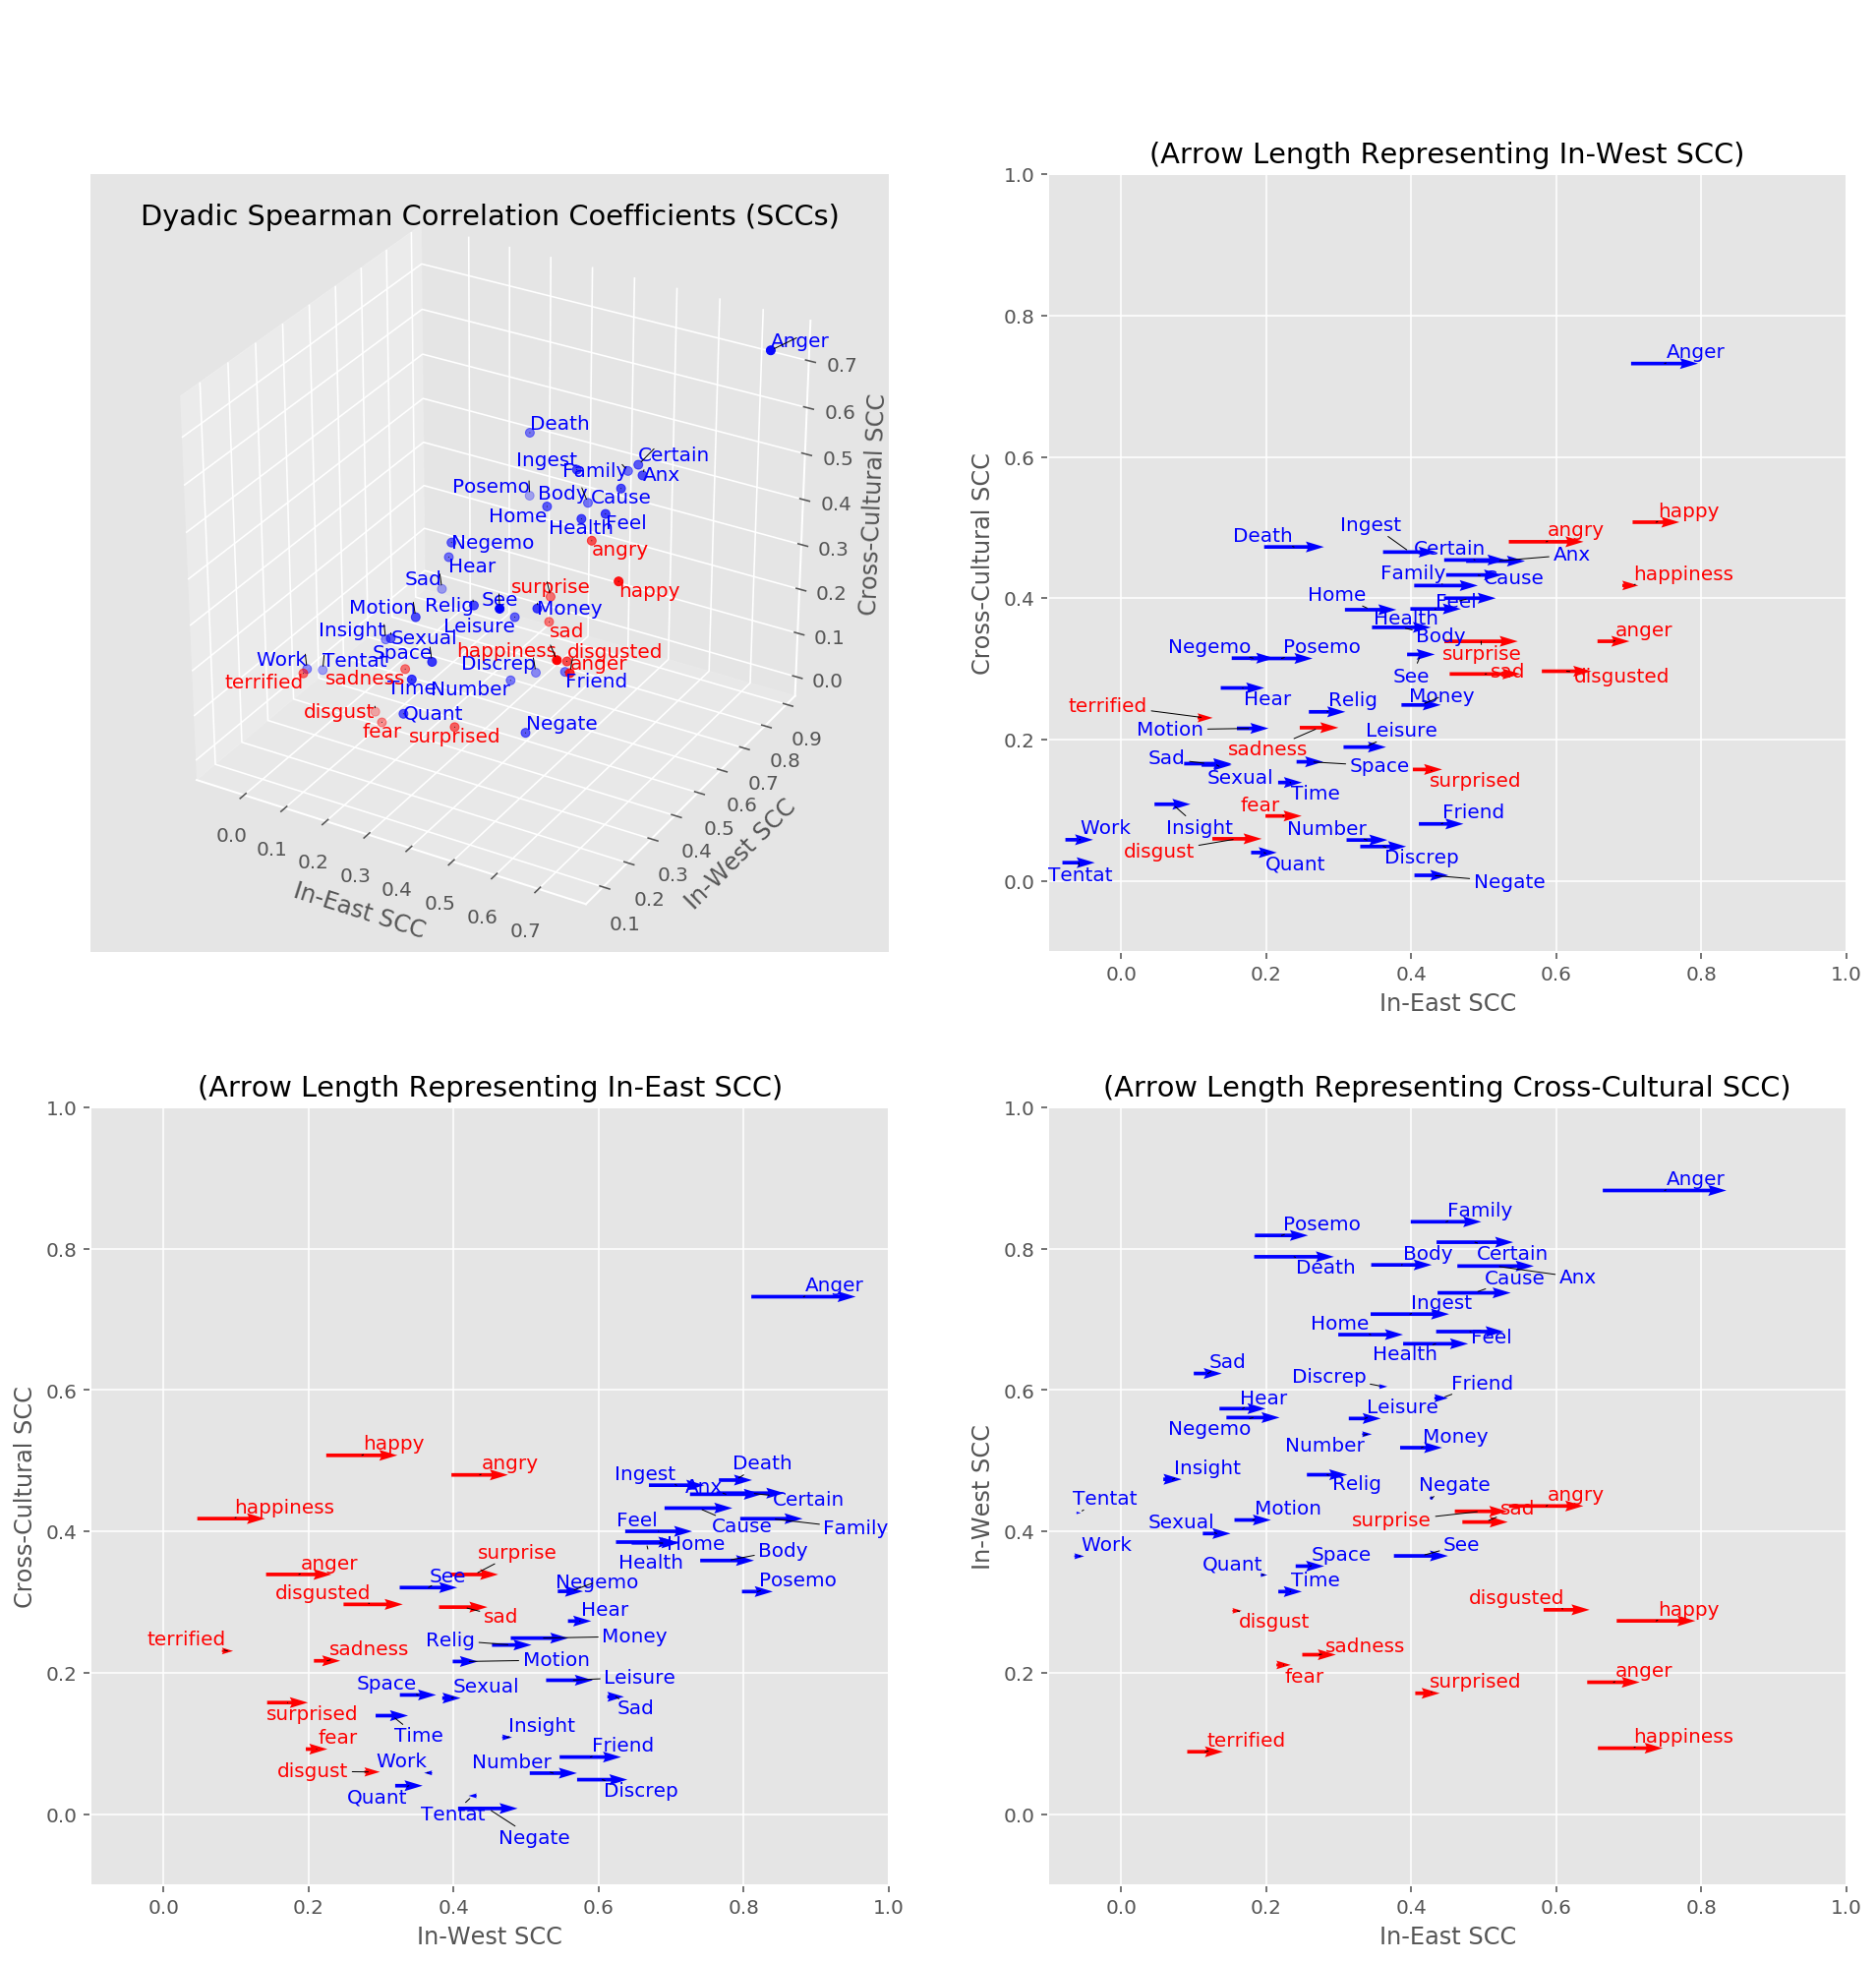

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from adjustText import adjust_text

fig = plt.figure(figsize=(16, 16))
points_to_keep = list(liwc_categories)+emotions_df.loc['en'].tolist()
ewc_df = df.loc[['east', 'west', 'cross'], points_to_keep].T#].drop(['proj', 'hofs'], axis=1).T

print('Working on 1...')
ax = fig.add_subplot(221, projection='3d')
texts = [ax.text(i.east, i.west, i.cross,  f'{label}', color='red' if label==label.lower() else 'blue') for label, i in ewc_df.iterrows()]
_ = ewc_df.iloc[:-12]
ax.scatter(xs=_.east, ys=_.west, zs=_.cross, color='blue', depthshade=True)
_ = ewc_df.iloc[-12:]
ax.scatter(xs=_.east, ys=_.west, zs=_.cross, color='red', depthshade=True)
ax.set_xlabel('In-East SCC')
ax.set_ylabel('In-West SCC')
ax.set_zlabel('Cross-Cultural SCC')
ax.set_title('Dyadic Spearman Correlation Coefficients (SCCs)')
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), expand_text=(2, 2))

print('Working on 2...')
ax = fig.add_subplot(222)
texts = [ax.text(i.east, i.cross,  f'{label}', color='red' if label==label.lower() else 'blue') for label, i in ewc_df.iterrows()]
_ = ewc_df.iloc[:-12]
plt.quiver(_.east, _.cross, _.west, pd.np.zeros(len(_)), width=0.005, units='x', scale_units='x', color='blue', pivot='middle')
_ = ewc_df.iloc[-12:]
plt.quiver(_.east, _.cross, _.west, pd.np.zeros(len(_)), width=0.005, units='x', scale_units='x', color='red', pivot='middle')
ax.set_xlabel('In-East SCC')
ax.set_ylabel('Cross-Cultural SCC')
ax.set_xlim(-.1, 1)
ax.set_ylim(-.1, 1)
ax.set_title('(Arrow Length Representing In-West SCC)')
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), expand_text=(1.2, 1.2))

print('Working on 3...')
ax = fig.add_subplot(223)
texts = [ax.text(i.west, i.cross,  f'{label}', color='red' if label==label.lower() else 'blue') for label, i in ewc_df.iterrows()]
_ = ewc_df.iloc[:-12]
plt.quiver(_.west, _.cross, _.east, pd.np.zeros(len(_)), width=0.005, units='x', scale_units='x', color='blue', pivot='middle')
_ = ewc_df.iloc[-12:]
plt.quiver(_.west, _.cross, _.east, pd.np.zeros(len(_)), width=0.005, units='x', scale_units='x', color='red', pivot='middle')
ax.set_xlabel('In-West SCC')
ax.set_ylabel('Cross-Cultural SCC')
ax.set_xlim(-.1, 1)
ax.set_ylim(-.1, 1)
ax.set_title('(Arrow Length Representing In-East SCC)')
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), expand_text=(1.2, 1.2))

print('Working on 4...')
ax = fig.add_subplot(224)
texts = [ax.text(i.east, i.west,  f'{label}', color='red' if label==label.lower() else 'blue') for label, i in ewc_df.iterrows()]
_ = ewc_df.iloc[:-12]
plt.quiver(_.east, _.west, _.cross, pd.np.zeros(len(_)), width=0.005, units='x', scale_units='x', color='blue', pivot='middle')
_ = ewc_df.iloc[-12:]
plt.quiver(_.east, _.west, _.cross, pd.np.zeros(len(_)), width=0.005, units='x', scale_units='x', color='red', pivot='middle')
ax.set_xlabel('In-East SCC')
ax.set_ylabel('In-West SCC')
ax.set_xlim(-.1, 1)
ax.set_ylim(-.1, 1)
ax.set_title('(Arrow Length Representing Cross-Cultural SCC)')
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), expand_text=(1.2, 1.2))

plt.show()